# Сонификация данных #

## Добро пожаловать! ##

Эта программа поможет вам озвучить ваши данные, превращая цифры в мелодии :)

Сонификация = озвучивание данных.

Для программы подходят файлы Excel (в форматах .xls, .xlsx), содержащие числовые данные. 

Полный список доступных музыкальных инструментов можно посмотреть: 
* [вот тут **на русском** (клик)](http://www.7not.ru/arrange/gm_instr.phtml)
* [вот тут **на английском** (клик)](https://soundprogramming.net/file-formats/general-midi-instrument-list/)
* [и тут на английском](https://msu.edu/course/mus/441/snapshot.afs/sullivan/fs02/MidiFiles/GenMidiInstList.html), просто чуть-чуть в другом формате.

Сэмплы инструментов и их звучание, воспроизводимое разными MIDI-интерпретаторами, можно послушать [вот тут](https://freewavesamples.com/).

[**ТУТ ИНСТРУКЦИЯ**](https://drive.google.com/file/d/1LV7U5F8JFAnFdOuY6GDsTQWyb8H5s-9m/view?usp=sharing), как пользоваться Jupyter Notebook или Google Colab, если вы впервые в жизни сталкиваетесь с необходимостью работать с подобными программами.

[**СКРИНКАСТ**](https://youtu.be/4x3ijzaJLQI) работы с программой.

## Начало. Стартовые ячейки для запуска ##

В этих ячейках собраны важные функции и библиотеки языка Python, без которых программа работать не будет.

**Запустите их перед использованием программы!**

Ячейку ниже (*# Ячейка №0*) нужно запустить **один раз** при **первом** запуске программы. 

После загрузки *Ячейки №0* в панели управления Jupyter Notebook выберите Kernel - Restart, а в Google Colab: Runtime - "Restart runtime...".

В дальнейшем – или в случае, если у вас уже установлены эти библиотеки – запускать эту ячейку больше не нужно.

In [ ]:
# Ячейка №0

!pip install pygame
!pip install midiutil

#### Для начала работы программы запустите ячейки ниже:  ####

***Ячейки №1-3***

Когда вы дойдёте до конца стартовых ячеек, вы увидите "**Ура!**..."

In [2]:
# Ячейка №1

import io
import math
import pygame
import pandas as pd
from time import sleep
import ipywidgets as widgets
import matplotlib.pyplot as plt
from midiutil.MidiFile import MIDIFile
%matplotlib inline

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [42]:
# Ячейка №2

def choose_your_style_and_write_to_midi (input_data, custom_instrument, custom_tempo, custom_duration):
    
    '''Функция, частично заимствованная из репозитория sonify пользовательницы erinspace. 
    Принимает на вход числовые данные (input_data) и возвращает файл midi (аудио), 
    используя заданные пользователем настройки: инструмент (custom_instrument), 
    темп (custom_tempo), длительность звука (custom_duration).
    В библиотеке sonify базовой нотой (base_pitch) было значение 60, которой присваивалась нота "до".
    В данной библиотеке отсчёт идёт от 0.'''
    
    memfile = io.BytesIO()
    midifile = MIDIFile(1, adjust_origin=False)  
    
    track = 0
    time = 0
    channel = 0
    
    base_pitch = 0 #Базовая нота, с которой начинается отсчёт. Меньше значение - ниже звук, больше - выше. 
                    #Переходит вниз, когда достигает максимума
    
    duration = custom_duration #Длительность нот (четверти, восьмушки, шестнадцатые), а не скорость их проигрывания
    volume = 100
    
    midifile.addTempo(track, time, custom_tempo) 
                                        # Скорость проигрывания. 
                                        # Чем меньше значение, тем дольше длится нота и тем длиннее трек проигрывается.
                                        # Чем больше значение, тем короче звучит нота и тем быстрее трек проигрывается.
                                        # Верхнего порога нет, можно ставить сколь угодно большое значение.
                
    midifile.addProgramChange(0, 0, 0, custom_instrument)   
                                        # Третье значение относится к минимальной длительности всего трека в секундах (битах). 
                                        # Даже если данных будет не хватать, трек будет продолжаться тишиной.
                                        # Последнее значение относится к инструменту.

    # Write the notes we want to appear in the file
    for point in input_data:
        time = point[0]
        pitch = base_pitch + int(point[1])
        midifile.addNote (track, channel, pitch, time, duration, volume)
    midifile.writeFile (memfile)
    
    return memfile
    

def play_memfile_as_midi(memfile):
    
    ''' Функция, частично заимствованная из репозитория sonify пользовательницы erinspace.
    Работает в паре с функцией choose_your_style_and_write_to_midi(), принимая на вход результат её применения (midi-файл)
    и воспроизводя его в браузере без сохранения в файл.
    https://stackoverflow.com/questions/27279864/generate-midi-file-and-play-it-without-saving-it-to-disk '''
    
    print('Воспроизведение начинается!')
    pygame.init()
    pygame.mixer.init()
    memfile.seek(0)  # "rewind" the memFile to play from the beginning
    pygame.mixer.music.load(memfile)
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        sleep(1)
    print('Воспроизведение завершено!')


def play_midi_from_data(input_data, custom_instrument = 0, custom_tempo = 300, custom_duration = 1):
    
    """
    Функция принимает на вход числовые данные в нужном формате (см. ниже, input_data) 
    и помогает проигрывать их с заданными параметрами.
    
    input_data: либо список кортежей, либо список списков, либо список списков кортежей, чтобы добавить отдельные треки.    
    пример:
    input_data = [(1, 5), (5, 7)] ИЛИ
    input_data = [
        [(1, 5), (5, 7)],
        [(4, 7), (2, 10)]
    ]
    Первое значение в кортеже относится к временной точке, на момент которой появляется данный звук. 
    Второе значение в кортеже относится к высоте звука. 
    """
    
    memFile = choose_your_style_and_write_to_midi(input_data, custom_instrument, custom_tempo, custom_duration)
    play_memfile_as_midi(memFile)
    
    
def custom_row_or_col_to_song (input_data, rows_or_columns, which_needed_value, bottom_border = 0, top_border = 127):
    
    ''' Функция принимает на вход пандас-датафрейм с числовыми данными (input_data), 
    забирает данные из нужного ряда/ столбца (зависит от пользовательского выбора) 
    и нормализует данные до ряда, пригодного для сонификации. 
    Значения полученного ряда: от 0 до 127 при запуске функции с настройками по умолчанию
    или от нижнего пользовательского порога до верхнего пользовательского порога
    при выборе пользователем других параметров для сонификации.'''
    
    if top_border > 127:
        print ('Слишком высокое значение верхнего порога! Измените')
        return
    if bottom_border < 0:
        print ('Слишком низкое значение нижнего порога! Измените')
        return
    if top_border < bottom_border:
        print ('Значения верхнего и нижнего порогов стоят не в том порядке, наоборот! Поменяйте')
        return
    
    custom_sound_span = top_border - bottom_border
    
    if custom_sound_span == 0:
        custom_sound_span = 1
    
    # Для рядов
    if rows_or_columns == 'В ряду':
        data_location = input_data.index.get_loc(which_needed.value)
        data_needed = input_data.iloc[data_location, :]
        span = data_needed.max() - data_needed.min()
        
        if span == 0:
            span = 1
            
        if data_needed.min() <= 0:
            new_list = []
            for i in data_needed:
                k = i + data_needed.min()*(-1) + 1
                print (i, k)
                new_list.append(k)
            data_needed = pd.Series (new_list)
        
        if (data_needed.max() <= top_border) & (data_needed.min() >= bottom_border):
            input_data.append (data_needed)
            
        else:
            list_to_song = []
            for i in data_needed:
                z = round(i/(span/custom_sound_span)-(data_needed.min()
                                                      /math.floor(span/custom_sound_span))) + bottom_border
                if z == 128:
                    z = z-1
                if (z > bottom_border) & (z < (bottom_border + 1)):
                    z = bottom_border + 1
                else:
                    z = round (z)
                list_to_song.append(z)
            input_data = input_data.append (pd.Series (list_to_song, index=input_data.columns), ignore_index=True)
        normalized_list = list (input_data.iloc[-1,:])
        return normalized_list
    
    # В столбце
    if rows_or_columns == 'В столбце':
        data_location = input_data.columns.get_loc(which_needed.value)
        data_needed = input_data.iloc[:, data_location]
        span = data_needed.max() - data_needed.min()
        
        if span == 0:
            span = 1
            
        if data_needed.min() <= 0:
            new_list = []
            for i in data_needed:
                k = i + data_needed.min()*(-1) + 1
                new_list.append(k)
            data_needed = pd.Series (new_list)
        
        if (data_needed.max() <= top_border) & (data_needed.min()>= bottom_border):
            input_data['normalized_column']= data_needed
            
        else:
            list_to_song = []
            for i in data_needed:
                
                for_division = math.floor(span/custom_sound_span)
                
                if for_division == 0:
                    for_division = 1
                
                z = i / (span / custom_sound_span) - (data_needed.min() / for_division) + bottom_border
                if z == 128:
                    z = z-1
                if (z > bottom_border) & (z < (bottom_border + 1)):
                    z = bottom_border + 1
                else:
                    z = round (z)
                list_to_song.append(z)
            input_data['normalized_column']= list_to_song
        normalized_list = list (input_data['normalized_column'])
        return normalized_list

def play_and_see (custom_or_default, straight_or_reverse, 
                  input_data, rows_or_columns, which_needed_value, 
                  custom_instrument, custom_tempo, custom_duration,
                  bottom_border = 0, top_border = 127):
    
    ''' Функция позволяет воспроизвести данные с нужными настройками в виде аудиофайла, 
    а затем нарисовать соответствующий график. Данные, равные 0, при воспроизведении становятся паузой.'''
    
    if custom_or_default == 'default':
        list_to_melody = custom_row_or_col_to_song (input_data, rows_or_columns, which_needed_value)
        if straight_or_reverse == 'reverse':
            list_to_melody.reverse()
        elif straight_or_reverse == 'straight':
            pass
        melody = []
        timing = 1
        for i in list_to_melody:
            if i == 0:
                timing = timing + 1
                continue
            melody.append ((timing, i))
            timing = timing + 1
        
    if custom_or_default == 'custom':
        list_to_melody = custom_row_or_col_to_song (input_data, rows_or_columns, which_needed_value, 
                                                    custom_bottom_border, custom_top_border)
        if straight_or_reverse == 'reverse':
            list_to_melody.reverse()
        elif straight_or_reverse == 'straight':
            pass
        melody = []
        timing = 1
        for i in list_to_melody:
            if i == custom_bottom_border:
                timing = timing + 1
                continue
            melody.append ((timing, i))
            timing = timing + 1
    print (melody)
    play_midi_from_data(melody, custom_instrument, custom_tempo, custom_duration)
    plt.scatter(*zip(*melody))
    plt.xlabel("Время")
    plt.ylabel("Высота звука")
    plt.show()
    return melody

In [4]:
# Ячейка №3

# ИНСТРУМЕНТЫ

# Клавишные
piano = {'рояль':1, 'яркий рояль':2, 
         'тапёрское пианино':3, 
         'электропианино 1': 4, 'электропианино 2': 5, 
         'клавесин':6, 'клавинет':7}

# Хроматические ударные
chromatic_percussion = {'челеста':8, 'колокольчики':9, 
         'музыкальная шкатулка':10, 'вибрафон':11, 
         'маримба':12, 'ксилофон':13, 
         'колокола':14, 'сантур/ дульцимер':15}

# Органы
organ = {'электронный орган':16, 'орган с перкуссией':17, 
         'рок-орган':18, 'церковный орган':19, 
         'деревянный органчик/ фисгармония':20, 'аккордеон':21, 
         'ручная гармоника':22, 'танго-аккордеон':23}

# Гитары
guitar = {'нейлоновые струны':24, 'стальные струны':25, 
         'джазовая электрогитара':26, 'обычная электрогитара':27, 
         'засурдиненная электрогитара':28, 'эффект овердрайв':29, 
         'эффект дисторшн':30, 'флажолет':31}

# Басы
bass = {'контрабас-пицикато':32, 'бас-гитара':33, 
         'безладовая бас-гитара':34, 'спокойная бас-гитара':35, 
         'слэп 1':36, 'слэп 2':37, 
         'синтетический бас 1':38, 'синтетический бас 2':39}

# Струнные
strings = {'скрипка':40, 'альт':41, 
         'виолончель':42, 'контрабас':43, 
         'тремоло струнных':44, 'пиццикато струнных':45, 
         'арфа':46, 'литавры':47}

# Групповые тембры
ensemble = {'струнная группа 1':48, 'струнная группа 2':49, 
         'синтетические струнные 1':50, 'синтетические струнные 2':51, 
         'хор на слог "а"':52, 'голос на слог "о"':53, 
         'синтетический голос':54, 'удар всем оркестром':55}

# Медные духовые
brass = {'труба':56, 'тромбон':57, 
         'туба':58, 'труба с сурдиной':59, 
         'валторна':60, 'медная группа':61, 
         'синтетические медные 1':62, 'синтетические медные 2':63}

# Деревянные духовые
reed = {'сопрано-саксофон':64, 'альт-саксофон':65, 
         'тенор-саксофон':66, 'баритон-саксофон':67, 
         'гобой':68, 'английский рожок':69, 
         'фагот':70, 'кларнет':71}

# Трубчатые
pipe = {'флейта-пикколо':72, 'флейта':73, 
         'блокфлейта':74, 'пан-флейта':75, 
         'бутылки':76, 'сякухати':77, 
         'свисток':78, 'окарина':79}

# Синтезаторы
synth_lead = {'прямоугольная волна':80, 'синусоидальная волна':81, 
         'каллиопа (паровой орган)':82, 'chiff':83, 
         'чаранго':84, 'голос':85, 
         'квинты':86, 'бас + синтезатор':87}

# Клавиатуры
synth_pad = {'новый век/ фантазия':88, 'тёплый':89, 
         'полисинтетический':90, 'хор':91, 
         'воздушный/ дугой':92, 'металлический':93, 
         'ореол (halo)':94, 'развертывающийся':95}

# Синтетические эффекты
synth_effects = {'дождь':96, 'саундтрек':97, 
         'кристалл':98, 'атмосфера':99, 
         'яркость':100, 'гоблины':101, 
         'эхо':102, 'научная фантастика (sci-fi)':103}

# Народные
ethnic = {'ситар':104, 'банджо':105, 
         'сямисэн':106, 'кото':107, 
         'калимба':108, 'волынка':109, 
         'народная скрипка':110, 'шахнай':111}

# Ударные
percussive = {'колокольчики':112, 'агого':113, 
         'стальные барабаны':114, 'деревянная коробочка':115, 
         'тайко':116, 'мелодичный том-том':117, 
         'электронные барабаны':118, 'тарелка задом наперёд':119}

# Звуковые эффекты
sound_effects = {'свист гитарной струны':120, 'придыхание':121, 
         'прибой':122, 'птичий щебет':123, 
         'телефонный звонок':124, 'вертолёт':125,
         'аплодисменты':126, 'выстрел':127}

**Ура!** Стартовые ячейки закончились. Дальше начинается уже непосредственно работа с программой.

## Настройка аудиодорожки ##

**Установите темп проигрывания и длительность нот.** 

Для этого запустите *Ячейку №4*.

Это **обязательный** шаг. 

**Мы предлагаем** вам для начала попробовать установить **темп 300** и **длительность** нот **2**, но затем попробуйте изменять их, подбирая оптимальное для вас значение. 

**Длительность нот** — это то, к чему в обычной нотной грамоте относятся четверти, восьмушки, шестнадцатые. То есть это длительность звуков, а не скорость их проигрывания.

**Темп** — это скорость проигрывания. **Чем меньше** значение, тем больше временное расстояние между звуками и **тем дольше** трек проигрывается. **Чем больше** значение, тем меньше расстояние между звуками и **тем быстрее** трек проигрывается. Верхнего порога нет, можно ставить сколь угодно большое значение. 

Темп измеряется в **BPM** — Beats Per Minute, то есть **в битах за минуту**. 100 BPM означает, что в минуту условный музыкант мог бы сыграть 100 четвертных нот (= четвертей) за одну минуту. В классической музыкальной теории "четверть" — это длительность 1/4 такта, то есть некого стабильного (и довольно краткого) временного периода, позволяющего равномерно делить музыку на временные отрезки. Больше про темп в MIDI можно почитать [тут](http://midi.teragonaudio.com/tech/midifile/ppqn.htm).

**Выбрать инструмент** можно в отведённых для этого ячейках **ниже**. Без выбора инструмента аудио проигрываться не будут.

In [18]:
# Ячейка №4

#Установите настройки аудиодорожки

custom_tempo = int (input())
custom_duration = int (input())

print (f'Текущий темп равен {custom_tempo}, длительность нот равна {custom_duration}')

try:
    print (f'Текущий выбранный инструмент: {custom_instrument_name} под номером {custom_instrument}')

except NameError:
    print ('Вы ещё не выбрали инструмент. Выберите его и возвращайтесь сюда :)')  

1200
20
Текущий темп равен 1200, длительность нот равна 20
Текущий выбранный инструмент: колокольчики под номером 9


### Тестовые данные ###

Это песочница. Меняя темп, длительность и инструмент, вы можете услышать на этих тестовых данных, как меняется звучание.

В *Ячейке №5* воспроизводятся четыре трека. Первый — наобум выбранные ноты, второй — начало алфавитной песенки "A, B, C, D, E, F, G", третий — результат объединения первых двух треков в единое аудио (да, так можно делать путём сложения), четвёртый — ещё одни наобум выбранные ноты. После воспроизведения появится график полученных треков.

В *Ячейке №6* маленькие данные, выбранные наобум, без графика. Эту ячейку удобнее использовать, когда вы хотите очень быстро прослушать, как звучат инструмент/ темп/ длительность, чтобы понять, подходят ли вам эти параметры.

In [ ]:
# Ячейка №5

# Пробные данные_ Большие
try:

    kek = [(1,2), (2.2,15), (2.5,34), (3, 68), (3, 100), (4,122)]
    simple_data = [(1, 50), (2, 50), (3, 57), (4, 57), (5, 59), (6, 59), (7, 57)]
    sample_data = [(1, 20), (2, 35), (3, 50), (4, 65), (5, 80), (6, 95), (7, 110)]
    play_midi_from_data(kek, custom_instrument, custom_tempo, custom_duration)
    play_midi_from_data(simple_data, custom_instrument, custom_tempo, custom_duration)
    play_midi_from_data(kek+simple_data, custom_instrument, custom_tempo, custom_duration)
    play_midi_from_data(sample_data, custom_instrument, custom_tempo, custom_duration)

except NameError: 
    
    print ('Вы ещё не выбрали либо инструмент, либо темп, либо длительность, поэтому данные не сонифицированы.')
    print ('Выберите их и возвращайтесь сюда :)')
    
# Как это выглядит
plt.scatter(*zip(*kek))
plt.scatter(*zip(*simple_data))
plt.scatter(*zip(*sample_data))
plt.xlabel("Время")
plt.ylabel("Высота звука")
plt.show()

In [ ]:
# Ячейка №6

# Пробные данные_ Маленькие

try:
    
    kek2 = [(1,2), (2.2,24), (2.7,42), (3, 68), (3, 101), (4,122), (5,93)]
    play_midi_from_data(kek2, custom_instrument, custom_tempo, custom_duration)

except NameError: 
    
    print ('Вы ещё не выбрали либо инструмент, либо темп, либо длительность, поэтому данные не сонифицированы.')
    print ('Выберите их и возвращайтесь сюда :)')

#### Тренировка ####

Также вы можете потренироваться на официальной статистике новых случаев заболевания коронавирусом в России с 26 января по 26 мая. Источник данных: [Европейский центр профилактики и контроля заболеваний](www.ecdc.europa.eu).

**Датасет:** [**скачать вот тут**](https://drive.google.com/file/d/14HxlDxsm4Qtb2V_a-5PLP1hQxzLXdVcQ/view?usp=sharing).

Для тренировки вам нужно:
1. Скачать датасет и импортировать его.
2. Выбрать для сонификации столбец cases (случаи).
3. Выбрать инструмент, темп, длительность.
4. Сонифицировать данные в изначальном порядке (то есть от мая к январю, т.к. данные в датасете идут от новейших к старейшим) с параметрами звукового ряда по умолчанию, то есть с полным звуковым рядом от 0 до 127. 
5. Сонифицировать в обратном порядке (от января к маю) с параметрами по умолчанию.
6. Задать пользовательский звуковой ряд и сонифицировать данные в изначальном порядке.
7. Сонифицировать данные в обратном порядке с пользовательским звуковым рядом.

## Импортируем файл ##

Чтобы **загрузить файл**, запустите ***Ячейку №7*** и напишите в выпадающем окошке полное название файла вместе с расширением в формате "Test_data.xlsx". 

Для программы подходят файлы Excel (**в форматах .xls, .xlsx**), содержащие **числовые данные**. Там могут содержаться и другие типы данных (например, текст), но в этой программке сонифицировать можно только числа. Проследите, чтобы в том столбце или ряду, который вы хотите сонифицировать, содержались исключительно числовые данные.

Запустите ***Ячейку №8*** и выберите **в выпадающем меню** (в виджете), хотите ли вы **взять данные** для сонификации **из ряда или из столбца**. Ячейку достаточно запустить один раз. Впоследствии, **если** вы захотите **изменить** значение виджета, **повторно запускать** ячейку с виджетом **не надо**. Просто сделайте другой выбор.

Затем запустите ***Ячейку №9*** и выберите **в выпадающем меню** (в виджете), тот **конкретный ряд или столбец**, который вы хотите сонифицировать. Впоследствии для изменения решения эту ячейку также не нужно запускать повторно, просто сделайте другой выбор. 

При этом, **если** вы **поменяли выбор** в ***Ячейке №8***, то ***Ячейку №9*** также нужно **перезапустить**. 

**Если** вы загрузили **новый файл** в *Ячейке №7*, то ***Ячейку №8*** можно **не перезапускать**, а вот ***Ячейку №9*** — **нужно**.

In [24]:
# Ячейка №7

name_of_file = input ('Введите название файла: ')
pandas_dic = pd.read_excel (name_of_file)
pd.set_option ('display.max_rows', pandas_dic.shape[0] + 1)
display (pandas_dic)

Введите название файла: Температура.xlsx


,c1,ht,needed_temp,needed_temp_2
0,00:00,+2°,2,18
1,03:00,+2°,2,18
2,06:00,+1°,1,17
3,09:00,+0°,0,16
4,12:00,-2°,-2,14
5,15:00,-2°,-2,14
6,18:00,-3°,-3,13
7,21:00,-2°,-2,14
8,24:00,-2°,-2,14
9,00:00,-2°,-2,14


In [9]:
# Ячейка №8

rows_or_columns = widgets.Dropdown(
    options = ['В ряду', 'В столбце'],
    description = 'Где данные?',
    disabled = False,
)
display (rows_or_columns)

Dropdown(description='Где данные?', options=('В ряду', 'В столбце'), value='В ряду')

In [25]:
# Ячейка №9

if rows_or_columns.value == 'В ряду':
    which_needed = widgets.Dropdown(
        options = pandas_dic.index,
        description = 'Индекс ряда',
        disabled = False,
    )
    display (which_needed)
if rows_or_columns.value == 'В столбце':
    which_needed = widgets.Dropdown(
        options = pandas_dic.columns,
        description = 'Столбец:',
        disabled = False,
    )
    display (which_needed)

Dropdown(description='Столбец:', options=('c1', 'ht', 'needed_temp', 'needed_temp_2'), value='c1')

# Сонификация #

### По умолчанию ###

В этой секции вы сможете сонифицировать ваши данные, используя **весь** доступный **разброс** звуков **от 0 до 127**. 

В ***Ячейке №10*** вы можете посмотреть на нормализированные **данные, выбранные** вами **для сонификации**, в виде списка. "Нормализированные" означает, что они уже приведены к формату ряда **от 0 до 127**.

В ***Ячейке №11*** данные переводятся в формат, пригодный для превращения в аудио, воспроизводятся и отображаются на графике **в изначальном порядке**. 

Формат данных — [(a, b), (c, d)]. Здесь видно и момент, в который нота вступает, и её значение: 
* "a", "c" — момент, в который нота вступает в BPM (битах за минуту, см. рубрику "Настройка аудиодорожки); 
* "b", "d" — высота ноты, то есть её числовое значение.

В ***Ячейке №12*** данные переводятся в формат, пригодный для превращения в аудио, воспроизводятся и отображаются на графике **в обратном порядке**. 

In [43]:
# Ячейка №10

#Посмотреть на получившийся ряд без тайминга

try:
    
    print (custom_row_or_col_to_song (pandas_dic, rows_or_columns.value, which_needed.value))

except NameError:
    
    print ('Кажется, вы ещё не выбрали все необходимые параметры для сонификации!')
    print ('Проверьте, загрузили ли вы файл, выбрали ли нужный ряд/ столбец.')
    print ('А затем возвращайтесь сюда :)')

[18, 18, 17, 16, 14, 14, 13, 14, 14, 14, 15, 15, 16, 16, 17, 18, 17, 18, 18, 18, 17, 17, 18, 18, 17, 16, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 17, 16, 16, 17, 17, 16, 16, 16, 16, 16, 16, 15, 16, 15, 15, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 17, 17, 16, 15, 16, 16, 18, 17, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 13, 14, 12, 12, 12, 10, 12, 15, 16, 15, 15, 16, 16, 17, 17, 17, 18, 18, 18, 18, 17, 17, 15, 16, 16, 17, 17, 17, 15, 16, 16, 17, 17, 17, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 19, 19, 19, 19, 18, 17, 18, 18, 16, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 19, 19, 18, 18, 18, 18, 18, 17, 17, 19, 19, 19, 19, 20, 20, 18, 17, 17, 17, 16, 16, 15, 15, 15, 14, 13, 12, 12, 12, 11, 11, 10, 10, 12, 11, 12, 14, 16, 17, 17, 17, 17, 18, 18, 17, 18, 18, 17, 16, 16, 16, 15, 15, 15, 15, 15, 15, 16, 17, 17, 18, 18, 16, 15, 15, 13, 12, 12, 12, 10, 10, 10, 11, 12, 12,

Воспроизведение в **изначальном** порядке:

In [ ]:
# Ячейка №11

# Перевести в формат, пригодный для превращения в аудио, воспроизвести и отобразить на графике
# Полный звуковой ряд от 0 до 127
# Момент, когда нота вступает, — первая цифра кортежа; вторая цифра — значение ноты (высота).
# В ИЗНАЧАЛЬНОМ порядке

try:
    
    melody = play_and_see ("default", "straight", 
                      pandas_dic, rows_or_columns.value, which_needed.value, 
                      custom_instrument, custom_tempo, custom_duration)
    
except NameError:
    
    print ('Кажется, вы ещё не выбрали все необходимые параметры для сонификации!')
    print ('Проверьте, загрузили ли вы файл, выбрали ли инструмент, темп и длительность.')
    print ('А затем возвращайтесь сюда :)')

Воспроизведение в **обратном** порядке:

In [ ]:
# Ячейка №12

# Перевести в формат, пригодный для превращения в аудио, воспроизвести и отобразить на графике
# Полный звуковой ряд от 0 до 127
# Момент, когда нота вступает, — первая цифра кортежа; вторая цифра — значение ноты (высота).
# В ОБРАТНОМ порядке

try:
    
    melody = play_and_see ("default", "reverse", 
                      pandas_dic, rows_or_columns.value, which_needed.value, 
                      custom_instrument, custom_tempo, custom_duration)
    
except NameError:
    
    print ('Кажется, вы ещё не выбрали все необходимые параметры для сонификации!')
    print ('Проверьте, загрузили ли вы файл, выбрали ли инструмент, темп и длительность.')
    print ('А затем возвращайтесь сюда :)')

### С пользовательскими нижним и верхним порогами ###

В этой секции вы сможете сонифицировать ваши данные, используя ваш собственный, **пользовательский разброс звуков**. 

Зачастую при использовании полного звукового ряда от 0 до 127, доступного по умолчанию, нижние звуки воспроизводятся как глухие удары, а верхние звуки — фальцетом. Хотя по сути это звучание верно, для человеческого уха оно неприятно. Именно поэтому мы предоставили вам возможность выбрать нижний и верхний пороги звучания по вашему вкусу. Это повышает гибкость и благозвучие сонификации, хотя уменьшение звукового ряда неизбежно уменьшает и разнообразность звучания.

Обращаем ваше внимание, что **для нижнего порога** вы **не** можете выбрать значение **ниже 0**, а **для верхнего нельзя** выбрать значение **выше 127**. 

Запустите ***Ячейку №13*** и **впишите** значения для **нижнего порога** (самой басовой ноты) и **верхнего порога** (самой высокой ноты).

После этого, в ***Ячейке №14*** вы можете посмотреть на нормализированные **данные, выбранные** вами **для сонификации**, в виде списка. "Нормализированные" означает, что они уже приведены к формату ряда **от нижнего порога до верхнего порога**, где нижний и верхний порог задали вы сами.

В ***Ячейке №15*** данные переводятся в формат, пригодный для превращения в аудио, воспроизводятся и отображаются на графике **в изначальном порядке**. 

Формат данных — [(a, b), (c, d)]. Здесь видно и момент, в который нота вступает, и её значение: 
* "a", "c" — момент, в который нота вступает в BPM (битах за минуту, см. рубрику "Настройка аудиодорожки); 
* "b", "d" — высота ноты, то есть её числовое значение.

В ***Ячейке №16*** данные переводятся в формат, пригодный для превращения в аудио, воспроизводятся и отображаются на графике **в обратном порядке**. 

In [21]:
# Ячейка №13

custom_bottom_border = int (input ('Введите нижний порог: '))
custom_top_border = int (input ('Введите верхний порог: '))

Введите нижний порог: 28
Введите верхний порог: 126


In [ ]:
# Ячейка №14

#Посмотреть на получившийся ряд без тайминга

print (custom_row_or_col_to_song (pandas_dic, rows_or_columns.value, which_needed.value,
                  custom_bottom_border, custom_top_border))

Воспроизведение в **изначальном** порядке:

[(1, 66), (2, 66), (3, 64), (4, 62), (5, 57), (6, 57), (7, 55), (8, 57), (9, 57), (10, 57), (11, 60), (12, 60), (13, 62), (14, 62), (15, 64), (16, 66), (17, 64), (18, 66), (19, 66), (20, 66), (21, 64), (22, 64), (23, 66), (24, 66), (25, 64), (26, 62), (27, 60), (28, 60), (29, 60), (30, 60), (31, 60), (32, 60), (33, 60), (34, 60), (35, 62), (36, 62), (37, 62), (38, 64), (39, 62), (40, 62), (41, 64), (42, 64), (43, 62), (44, 62), (45, 62), (46, 62), (47, 62), (48, 62), (49, 60), (50, 62), (51, 60), (52, 60), (53, 57), (54, 57), (55, 57), (56, 57), (57, 57), (58, 57), (59, 57), (60, 60), (61, 60), (62, 60), (63, 60), (64, 60), (65, 62), (66, 62), (67, 62), (68, 64), (69, 64), (70, 64), (71, 64), (72, 64), (73, 64), (74, 62), (75, 60), (76, 62), (77, 62), (78, 66), (79, 64), (80, 66), (81, 64), (82, 64), (83, 64), (84, 64), (85, 64), (86, 64), (87, 64), (88, 64), (89, 64), (90, 64), (91, 64), (92, 62), (93, 62), (94, 62), (95, 62), (96, 62), (97, 55), (98, 57), (99, 53), (100, 53), (101, 5

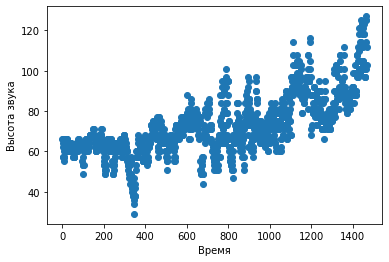

In [23]:
# Ячейка №15

# Перевести в формат, пригодный для превращения в аудио, воспроизвести и отобразить на графике
# Пользовательский звуковой ряд
# Момент, когда нота вступает, — первая цифра кортежа; вторая цифра — значение ноты (высота).
# В ИЗНАЧАЛЬНОМ порядке

try:
    
    melody = play_and_see ("custom", "straight", 
                  pandas_dic, rows_or_columns.value, which_needed.value, 
                  custom_instrument, custom_tempo, custom_duration,
                  custom_bottom_border, custom_top_border)
    
except NameError:
    
    print ('Кажется, вы ещё не выбрали все необходимые параметры для сонификации!')
    print ('Проверьте, загрузили ли вы файл, выбрали ли инструмент, темп и длительность, нижний и верхний пороги звучания.')
    print ('А затем возвращайтесь сюда :)')

Воспроизведение в **обратном** порядке:

In [ ]:
# Ячейка №16

# Перевести в формат, пригодный для превращения в аудио, воспроизвести и отобразить на графике
# Пользовательский звуковой ряд
# Момент, когда нота вступает, — первая цифра кортежа; вторая цифра — значение ноты (высота).
# В ОБРАТНОМ порядке

try:
    
    melody = play_and_see ("custom", "reverse", 
                      pandas_dic, rows_or_columns.value, which_needed.value, 
                      custom_instrument, custom_tempo, custom_duration,
                      custom_bottom_border, custom_top_border)
    
except NameError:
    
    print ('Кажется, вы ещё не выбрали все необходимые параметры для сонификации!')
    print ('Проверьте, загрузили ли вы файл, выбрали ли инструмент, темп и длительность, нижний и верхний пороги звучания.')
    print ('А затем возвращайтесь сюда :)')

# Сохранение #

Чтобы **сохранить** аудио, для начала запустите ***Ячейку №17*** и **введите** желаемое **название** трека.

**Затем** запустите ***Ячейку №18***, чтобы выгрузить файл.

Готово! Файл сохранён в репозиторий.

Впоследствии, **если** вы **поменяете настройки** трека, но захотите **сохранить** его **под тем же названием**, достаточно **повторно** запустить ***Ячейку №18***, а вот ***Ячейку №17*** перезапускать **не нужно**.

In [ ]:
# Ячейка №17

#Введите название трека

melody_name = input ('Введите название трека: ')

In [ ]:
# Ячейка №18

#Выгрузить аудио

try:

    melody_output=choose_your_style_and_write_to_midi(melody, custom_instrument, custom_tempo, custom_duration)
    with open (f"{melody_name}.mid", "wb") as f:
        f.write(melody_output.getbuffer())
        print (f'Файл "{melody_name}.mid" успешно сохранён!')
        
except:
    
    print ('Кажется, вы ещё не выбрали все необходимые параметры для сохранения!')
    print ('Проверьте, ввели ли вы название трека, загрузили ли вы файл.')
    print ('Выбрали ли вы инструмент, темп и длительность, нижний и верхний пороги звучания.')
    print ('А затем возвращайтесь сюда :)')

# Выбор инструмента #

В ходе работы с баблиотекой midiutil, выявлено:
* Инструмент "электронный рояль", находящийся в списке GeneralMIDI под номером 3, отсутствует в библиотеке.
* Из-за отсутствия "электронного рояля" все номера инструментов сдвинуты на "-1" по сравнению со стандартным списком GeneralMIDI.
* Инструменты под номерами 0, 1 и 128 идентичны и сохранены здесь под номером 1.

**Чтобы выбрать инструмент**: 
1. Сначала решите, к какой группе от относится.
2. В нужной группе инструментов (допустим, в "Хроматических ударных") запустите ячейку под чётным номером.
3. В выпадающем меню (виджете) выберите нужный вам инструмент (допустим, маримбу). 
4. Запустите ячейку под нечётным номером, следующую ниже.
5. Если вы захотите поменять группу инструментов, то просто идите туда и проделайте всё те же шаги. 
6. Если виджет (выпадающее меню) для определённой группы инструментов уже открыт, не стоит запускать ячейку повторно. Просто выберите другой инструмент, если это необходимо, и запустите ячейку ниже под нечётным номером.
7. Если вы забыли, какой инструмент выбирали последним, запустите *Ячейку №19*. Она находится прямо под этим текстом.

## Узнать текущий инструмент ##

In [ ]:
# Ячейка №19

try:
    print (f'Текущий выбранный инструмент: {custom_instrument_name} под номером {custom_instrument}')

except NameError:
    print ('Вы ещё не выбрали инструмент. Выберите его и возвращайтесь сюда :)')    

## Клавишные ##

#### Примечание. #### 
Согласно "Словарю иностранных слов" М.В. Петровой:

**"Тапёр"**  — это музыкант, чаще всего пианист, игравший на танцевальных вечерах и балах. Впоследствии тапёры сопровождали своей игрой немое кино.

Согласно сайту clavinet.com:

**"Клавинет"** — это электрогитара, контролируемая с помощью фортепианной клавиатуры. [Слушать](https://youtu.be/c7CY6aJtegc)

In [ ]:
# Ячейка №20

piano_widget = widgets.Dropdown(
    options = piano.keys(),
    description = 'Клавишные:',
    disabled = False,
)
display (piano_widget)

In [ ]:
# Ячейка №21

custom_instrument = piano [piano_widget.value]
custom_instrument_name = piano_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Хроматические ударные ##

#### Примечание. #### 

Согласно открытым источникам:

**"Хроматический"** означает, что музыкальный инструмент способен менять звук по полутонам (в отличие от барабанов, например).

**"Сантур"** — это персидский струнно-ударный музыкальный инструмент, на котором играют двумя лёгкими продолговатыми молоточками; род цимбалы. [Слушать](https://youtu.be/D_rhIvcffUk)

**"Дульцимер"** — чаще всего подразумевают североамериканский струнный инструмент, родственный цитре, с продолговатым корпусом и 3-4 струнами. Но есть и "дульцимер с молоточками" (hammered dulcimer), который больше похож на сантур. Именно он и имеется в виду в General MIDI. [Слушать](https://youtu.be/TxjpYHhfRyI)

Согласно сайту belcanto.ru:

**"Челеста"**  — это ударно-клавишный инструмент, внешне напоминающий фортепиано, а звучащий, как колокольчики. Именно с челесты начинается [главный саунтрек к фильмам про Гарри Поттера](https://youtu.be/Htaj3o3JD8I).

**"Вибрафон"** — это ударный инструмент с определенной высотой звучания, род металлофона. Металлические пластинки расположены в два ряда наподобие клавиатуры фортепиано. [Слушать](https://youtu.be/qZAouKLcGBU)

**"Колокольчики"** — это ударный инструмент, состоящий из 25-32 металлических пластинок, размещённых в плоском ящике ступенями в 2 ряда; верхний ряд соответствует чёрным, нижний — белым клавишам фортепиано. [Слушать](https://youtu.be/d_3QetFbF6c)

**"Колокола"** — это ударный инструмент, состоящий из 12-18 металлических труб-цилиндров, свободно подвешенных в П-образной раме-стойке высотой 2 м. [Колокола](https://youtu.be/QPyeU5c5s-g)

Согласно Большой российской энциклопедии:

**"Ксилофон"** — это ударный инструмент, состоящий из набора деревянных брусков, расположенных в определённом порядке. [Слушать](https://youtu.be/AhseOwKXpkQ)

**"Маримба"** — это африканский ударный инструмент, родственный ксилофону, состоящий из деревянных пластинок разной длины. [Слушать](https://youtu.be/mPr_SvnJ_z0)

In [14]:
# Ячейка №22

chromatic_percussion_widget = widgets.Dropdown(
    options = chromatic_percussion.keys(),
    description = 'Хр. ударные:',
    disabled = False,
)
display (chromatic_percussion_widget)

Dropdown(description='Хр. ударные:', options=('челеста', 'колокольчики', 'музыкальная шкатулка', 'вибрафон', '…

In [15]:
# Ячейка №23

custom_instrument = chromatic_percussion [chromatic_percussion_widget.value]
custom_instrument_name = chromatic_percussion_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

Вы выбрали инструмент "колокольчики" под номером 9.


## Органы ##

#### Примечание. #### 

Согласно открытым источникам:

**"Перкуссия"** — это ударные, шумовые инструменты и звук, появляющийся при игре на них. 

**"Пневматический инструмент"** —  тот, который звучит за счёт сжатого или движущегося воздуха.

Согласно сайту belcanto.ru:

**"Фисгармония"** — это клавишный пневматический инструмент, внешне напоминающий фортепиано. Музыкант попеременно нажимает две педали, за счёт чего раздуваются меха и выпускают воздушную струю, которая, в свою очередь, приводит в движение свободно проскакивающие металлические язычки. [Слушать](https://youtu.be/NUndR3llMHE?t=9)

**"Гармоника"** — то же самое, что и гармонь. **Не путать с губной гармоникой!** Тут имеется в виду клавишно-пневматический инструмент, внешне похожий на аккордеон, корпус которого состоит из двух частей и воздушного резервуара (меха) между ними. [Слушать](https://youtu.be/e7pYuOXmxTk)

In [ ]:
# Ячейка №24

organ_widget = widgets.Dropdown(
    options = organ.keys(),
    description = 'Органы:',
    disabled = False,
)
display (organ_widget)

In [ ]:
# Ячейка №25

custom_instrument = organ [organ_widget.value]
custom_instrument_name = organ_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Гитары ##

#### Примечание. #### 

Примеры эффектов **овердрайв** и **дисторшн** можно посмотреть [**здесь**](https://muz.by/muzblog/blog/overdrive-distortion-fuzz-chem-otlichayutsya-eti-gitarnye-effekty/).

Согласно сайту belcanto.ru:

**"Сурдина"** — это приспособление для приглушения звука (от латинского surdus — глухой, глухо звучащий).

**"Флажолет"** — это озвученные обертоны (≈ призвуки) на струнных инструментах. На смычковых флажолеты свистящие и напоминают флейту, на щипковых — звенящие, холодно-прозрачные. Также флажолеты могут получаться на флейте в результате передувания.

In [ ]:
# Ячейка №26

guitar_widget = widgets.Dropdown(
    options = guitar.keys(),
    description = 'Гитары:',
    disabled = False,
)
display (guitar_widget)

In [ ]:
# Ячейка №27

custom_instrument = guitar [guitar_widget.value]
custom_instrument_name = guitar_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Басы ##

#### Примечание. #### 

Согласно сайту belcanto.ru:

**"Пиццикато"** — это приём игры на струнных инструментах, когда звук извлекается не ведением смычка, а защипыванием струны.

Согласно сайту [h2g2.com](https://h2g2.com/edited_entry/A711802):

**"Безладовая гитара"** — это гитара, у которой нет металлических ладовых порожков. Музыкант может сам, пальцами, во время игры определять и регулировать длину струны и, соответственно, её звучание.

Согласно сайту [shkolamuzyki.ru](https://shkolamuzyki.ru/statii/title/priemy-igry-na-bas-gitare):

**"Слэп"** — это резкий удар большим пальцем по струне для получения четкого, острого звука. Используется в игре на струнных щипковых инструментах.

In [ ]:
# Ячейка №28

bass_widget = widgets.Dropdown(
    options = bass.keys(),
    description = 'Басы:',
    disabled = False,
)
display (bass_widget)

In [ ]:
# Ячейка №29

custom_instrument = bass [bass_widget.value]
custom_instrument_name = bass_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Струнные ##

#### Примечание. #### 

**Внимание!** Несмотря на то, что **литавры — ударный инструмент**, в General MIDI-классификации этот инструмент принято относить к струнным. Звучит в MIDI он тоже как ударный инструмент.

Согласно сайту belcanto.ru:

**"Тремоло"** — это многократное быстрое повторение одного звука, интервала или аккорда, а также чередование двух звуков, расположенных на расстоянии не менее малой терции.

**"Пиццикато"** — это приём игры на струнных инструментах, когда звук извлекается не ведением смычка, а защипыванием струны.

**"Литавры"** — ударный инструмент с котлообразным корпусом, сверху покрытым кожей (мембраной). [Слушать](https://youtu.be/izlZ7jiFWvc)

In [ ]:
# Ячейка №30

strings_widget = widgets.Dropdown(
    options = strings.keys(),
    description = 'Струнные:',
    disabled = False,
)
display (strings_widget)

In [ ]:
# Ячейка №31

custom_instrument = strings [strings_widget.value]
custom_instrument_name = strings_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Ансамбль. Групповые тембры ##

In [ ]:
# Ячейка №32

ensemble_widget = widgets.Dropdown(
    options = ensemble.keys(),
    description = 'Ансамбль:',
    disabled = False,
)
display (ensemble_widget)

In [ ]:
# Ячейка №33

custom_instrument = ensemble [ensemble_widget.value]
custom_instrument_name = ensemble_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Медные духовые ##

#### Примечание. #### 

Согласно сайту belcanto.ru:

**"Сурдина"** — это приспособление для приглушения звука (от латинского surdus — глухой, глухо звучащий).

In [ ]:
# Ячейка №34

brass_widget = widgets.Dropdown(
    options = brass.keys(),
    description = 'Медно-дух.:',
    disabled = False,
)
display (brass_widget)

In [ ]:
# Ячейка №35

custom_instrument = brass [brass_widget.value]
custom_instrument_name = brass_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Деревянные духовые ##

In [6]:
# Ячейка №36

reed_widget = widgets.Dropdown(
    options = reed.keys(),
    description = 'Дерев.-дух.:',
    disabled = False,
)
display (reed_widget)

Dropdown(description='Дерев.-дух.:', options=('сопрано-саксофон', 'альт-саксофон', 'тенор-саксофон', 'баритон-…

In [7]:
# Ячейка №37

custom_instrument = reed [reed_widget.value]
custom_instrument_name = reed_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

Вы выбрали инструмент "английский рожок" под номером 69.


## Трубчатые ##

#### Примечание. #### 

Согласно сайту belcanto.ru:

**"Пан-флейта", "Флейта Пана** — многоствольная продольная флейта, состоящая из открытых с одного конца трубочек разной длины, связанных ниткой, тростниковыми планками или жгутом из молодой коры вишнёвого дерева. Согласно мифу, нимфа Сиринкс, пытаясь спастись от преследований влюблённого Пана, взмолила о помощи к речному богу. Бог превратил её в тростник, из которого Пан и сделал флейту. [Слушать](https://youtu.be/A4MOouWqmTQ)

**"Сякухати"** — это японская продольная бамбуковая флейта. [Слушать](https://youtu.be/Sv2je9arNz4)

Согласно сайту eomi.ru:

**"Окарина"** — глиняная свистковая флейта, в переводе с итальянского языка "гусёнок", представляющая собой небольшую камеру в форме яйца с 4-13 отверстиями для пальцев. [Слушать](https://youtu.be/N_dEVsRg01g?t=29)

In [ ]:
# Ячейка №38

pipe_widget = widgets.Dropdown(
    options = pipe.keys(),
    description = 'Трубчатые:',
    disabled = False,
)
display (pipe_widget)

In [ ]:
# Ячейка №39

custom_instrument = pipe [pipe_widget.value]
custom_instrument_name = pipe_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Синтезаторы ##

#### Примечание. #### 
Согласно словарю Merriam-Webster:

**"Calliope"**  — это звуки парового органа, а именно свисты, издаваемые паром или сжатым воздухом. [Слушать](https://youtu.be/Olnm66Uxy8U?t=62)

**"Chiff"** — это звук, с которым воздух покидает рот при игре на духовых музыкальных инструментах. 

**"Чаранго"** — это маленькая латиноамериканская гитарка, корпус которой традиционно изготовляется из панцирей животных. [Слушать](https://youtu.be/0-yCgpckMSs?t=4)

In [ ]:
# Ячейка №40

synth_lead_widget = widgets.Dropdown(
    options = synth_lead.keys(),
    description = 'Синтезатор:',
    disabled = False,
)
display (synth_lead_widget)

In [ ]:
# Ячейка №41

custom_instrument = synth_lead [synth_lead_widget.value]
custom_instrument_name = synth_lead_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Клавиатуры ##

#### Примечание. #### 

Это лучше услышать, чем прочитать словами:

* [Новый век/ фантазия](https://youtu.be/mxOarPRulgE)
* [Тёплый](https://youtu.be/HDgdPNLw4R8)
* [Хор](https://youtu.be/1HSYAw3qLzY)
* [Воздушный/ дугой](https://youtu.be/lXMb768dGNI) (не очень репрезентативный, но классный пример)
* [Ореол (Halo)](https://youtu.be/8Jk0W8SJVi8)
* [Развёртывающийся](https://youtu.be/dzGeU9_FzYA)

In [ ]:
# Ячейка №42

synth_pad_widget = widgets.Dropdown(
    options = synth_pad.keys(),
    description = 'Клавиатуры:',
    disabled = False,
)
display (synth_pad_widget) 

In [ ]:
# Ячейка №43

custom_instrument = synth_pad [synth_pad_widget.value]
custom_instrument_name = synth_pad_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Синтетические эффекты ##

#### Примечание. #### 

К сожалению, тут для примера мы нашли только [Яркость](https://youtu.be/oAWeYqSUw-0).

In [ ]:
# Ячейка №44

synth_effects_widget = widgets.Dropdown(
    options = synth_effects.keys(),
    description = 'СинтЭффект',
    disabled = False,
)
display (synth_effects_widget) 

In [ ]:
# Ячейка №45

custom_instrument = synth_effects [synth_effects_widget.value]
custom_instrument_name = synth_effects_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Народные ##

#### Примечание. #### 
Согласно энциклопедии Britannica:

**"Ситар"** — это струнный инструмент из семества лютневых, популярный в Северной Индии, Пакистане и Бангладеше. Корпус глубокий, напоминает грушевидную тыкву, гриф деревянный и длинный, струны металлические. В длину инструмент достигает 1,2 м. [Слушать](https://youtu.be/zVqvd6mhat8)

**"Банджо"** — это струнный инструмент африканского происхождения, популяризированный рабами в США в XIX веке, а затем распространившийся в Европе. Корпус инструмента напоминает бубен, а струны пролегают по грифу наподобие скрипки. [Слушать](https://youtu.be/fnMhUPewk6c)

**"Сямисэн"** — это безладовая японская лютня с длинной шейкой, тремя шёлковыми струнами и маленьким квадратным корпусом, обтянутым кошачьей кожей. [Слушать](https://youtu.be/MgN_xIHqLUA)

**"Цитра"** — это любой струнный музыкальный инструмент, длина струн которого практически совпадает с длиной корпуса инструмента. [Слушать](https://youtu.be/hyHd4rDUd5g)

**"Кото"/ "Кин"** — это длинная японская цитра с 13 шёлковыми струнами и передвигаемым струнодержателем. Корпус традиционно сделан из павловнии (адамова дерева), инструмент достигает в длину 190 см. [Слушать](https://youtu.be/JDTp_YQizqE)

**"Шахнай"/ "Шанай"** — это гобой конической формы с двойной тростью из Северной Индии, способный охватить две октавы. [Слушать](https://youtu.be/hveeMDC6Dro)

Согласно словарю Merriam-Webster, Большой российской энциклопедии и сайту mus-instruments.ru:

**"Калимба"** — это "фортепиано для пальцев", берущее своё происхождение от цанцы (санзы/ занзы). Африканский язычковый щипковый (ламеллафон) самозвучащий (идиофон) музыкальный инструмент. На корпусе размещён ряд металлических пластин-язычков, которые и издают звук при задевании пальцем. [Слушать](https://youtu.be/miEE3vA6wGM)

In [ ]:
# Ячейка №46

ethnic_widget = widgets.Dropdown(
    options = ethnic.keys(),
    description = 'Народные:',
    disabled = False,
)
display (ethnic_widget) 

In [ ]:
# Ячейка №47

custom_instrument = ethnic [ethnic_widget.value]
custom_instrument_name = ethnic_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Ударные ##

#### Примечание. #### 

Согласно открытым источникам:

**"Агого"** — это бразильский народный инструмент, состоящий из двух металлических или деревянных колокольчиков, соединённых гибкой ручкой. Играют на инструменте деревянной палочкой, при этом за счёт гибкости ручки колокольчики во время игры могут ударяться друг о друга и также издавать звук. [Слушать](https://youtu.be/LI3pz72AqyM)

Согласно открытым источникам и [исследователям Стэнфордского университета](http://www.hangblog.org/panart/2-S2-4-IsmaRossing.pdf):

**"Стальной барабан"** — это инструмент, появившийся в XX веке в Республике Тринидад и Тобаго после принятия закона, запрещающего мембранные барабаны и бамбуковые палки для исполнения музыки. Для создания инструментов использовались тысячи металлических нефтяных бочек, оставленных на пляжах Тринидада после Второй мировой войны американцами и британцами. Родственные инструменты — ханги. [Слушать](https://youtu.be/oQ9MLlLv9GE)

Как звучит:

* [**Деревянная коробочка**](https://youtu.be/9k2pURqm1Aw?t=39)
* [**Тайко**](https://youtu.be/2yV1SO58AxU?t=54), японский барабан

In [ ]:
# Ячейка №48

percussive_widget = widgets.Dropdown(
    options = percussive.keys(),
    description = 'Ударные:',
    disabled = False,
)
display (percussive_widget) 

In [ ]:
# Ячейка №49

custom_instrument = percussive [percussive_widget.value]
custom_instrument_name = percussive_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Звуковые эффекты ##

In [ ]:
# Ячейка №50

sound_effects_widget = widgets.Dropdown(
    options = sound_effects.keys(),
    description = 'Зв.Эффект:',
    disabled = False,
)
display (sound_effects_widget) 

In [ ]:
# Ячейка №51

custom_instrument = sound_effects [sound_effects_widget.value]
custom_instrument_name = sound_effects_widget.value
print (f'Вы выбрали инструмент "{custom_instrument_name}" под номером {custom_instrument}.')

## Общая информация о программе ##

Автор программы: Мария Казакова, Москва, 2020 год

Контакты: marikasakowa@gmail.com